# Important Note:

This code produces all original visualizations in Figures 7, 8, and Extended Data Fig. 8, which make up a subset of the panels in those figures. All other panels in those figures and Extended Data Fig. 7 were created using publicly available R packages commonly used for interpreting and visualizing transcriptomic data, as described in the manuscript methods. As such, that code is not included in this repository. 

Raw transcriptomic data will be made publicly available upon manuscript publication via NCBI GEO. Processed transcriptomic data found in Supplemental Information Table S1 and S2 (both mentioned below) will also be made publicaly available in association with the manuscript. For convenience, the subset of processed transcriptomic data needed to reproduce Figs. 7F-G and 8B-D and Extended Data Fig. 8B-C and Q are included in the Dryad repository or as hard-coded arrays here. 

# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Create dict for data from RF mice that have IHC data'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice,['Y2','Y3','Y16','Y17','Y18','Y19','A12','A13','A3','A4','A5','A6','A7'], return_indices = True)

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [7]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
y_ind = []
age_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[age_ind]))
print(len(y_sind), len(age_sind))
Nold = len(mice[age_ind])
Nyoung = len(mice[y_ind])

['Y16' 'Y17' 'Y18' 'Y19' 'Y2' 'Y3'] ['A12' 'A13' 'A3' 'A4' 'A5' 'A6' 'A7']
6 7
31 42


# Edit these paths & define boxplot colormaps

In [8]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
fig5_folder = 'C:/Users/Python/Desktop/LocalData/Figure5/' 

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure78S8/'

In [9]:
''' Use density of spatial cells to get dot colormaps for subsequent boxplots'''

mper99 = []

for m, session in zip(mice,sessions):
    
    m_99 = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all spatial cell boolean
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        spatialcell = np.load(fig5_folder + spatialcell99_file)
        d['spatialcell'] = spatialcell
        m_99 = np.append(m_99, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
        
    mper99 = np.append(mper99, np.sum(m_99)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
''' Define ColorMaps for Session & Animal Boxplots of Mice that have IHC Data (Figure 8)'''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,Nold)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,Nyoung)])
col_animal = [col_animal_young, col_animal_old]

col_session_young = []
col_session_old = []
for m, session in zip(mice, sessions):
    print(m)
    
    for s in range(0,len(session)):
        
        if m in RF_aged_mice:
            idx = np.where(mice == m)[0][0]
            col_session_old.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young,col_session_old]

label_mice = ['Y16', 'Y17', 'Y18', 'Y19', 'Y2', 'Y3','A12', 'A13', 'A3', 'A4', 'A5', 'A6', 'A7']

# set up handles
from itertools import repeat
per99 = [mper99[y_ind], mper99[age_ind]]

handles = []
for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)

A12
A13
A3
A4
A5
A6
A7
Y16
Y17
Y18
Y19
Y2
Y3


# Figure 7F, G Visualizations of RF Transcriptomic Data Correlates of Spatial Coding

Other panels in Figure 7 were generated with publicly available packages listed in the manuscript methods. As such, the only code needed to reproduce these panels is shared. Raw and processed transcriptomic data will be made available to the public upon manuscript publication

In [11]:
''' Gather Figure 7F Data from Spreadsheet

This csv file contains coherence correlates sig. after FDR = 0.10 Benjamini-Hochberg correction (sigFDR = 1) or only at p < 0.05
(sigFDR = 0, sig = 1). The full results of coherence correlation analysis are found in Supplemental Information Table S1 of 
the manuscript, which includes all genes across the RF dataset.

'''
figure7f = pd.read_csv('C:/Users/Python/Desktop/Dryad/7F.csv') # adjust path name
figure7f.head()

sigcorrR = np.array(figure7f.loc[(figure7f.sigFDR == 1),'r'])
nscorrR = np.array(figure7f.loc[(figure7f.sigFDR == 0),'r'])

sigcorrp = np.array(figure7f.loc[(figure7f.sigFDR == 1),'padj'])
nscorrp = np.array(figure7f.loc[(figure7f.sigFDR == 0),'padj'])

n FDR-corrected sig negative vs. positive coherence correlates: 
290 vs. 26


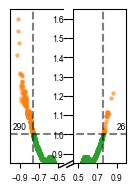

In [12]:
''' Plot Figure 7F

In Illustrator, the y-axis line was moved to be centered between these panels at the axis break, and y-axis tick labels were 
move to the right side of the axis for improved visibility.
 
'''

print('n FDR-corrected sig negative vs. positive coherence correlates: ')
print(str(len(np.array(figure7f.loc[(figure7f.sigFDR == 1) & (figure7f.r < 0),'Gene']))) + ' vs. ' + str(len(np.array(figure7f.loc[(figure7f.sigFDR == 1) & (figure7f.r > 0),'Gene']))))

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (1.5,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)
ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C1', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.set_xlim([-1,-0.45])
ax1.set_xticks([-0.9,-0.7,-0.5])
ax1.set_ylim([0.85,1.65])
ax1.yaxis.tick_right()
ax1.spines.right.set_visible(False)
ax1.tick_params(labelright = False, labelsize = 6)

ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C1', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.set_xlim([0.45,1])
ax2.set_xticks([0.5,0.7,0.9])
ax2.set_ylim([0.85,1.65])
ax2.spines.left.set_visible(False)
ax2.tick_params(labelleft = True, labelsize = 6)
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_yticks([0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6])
ax2.set_yticklabels([0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6])

#add vertical lines at FDR significance threshold
ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.85,1.65,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.85,1.65,'k','--',alpha = 0.5)
ax2.vlines(0.45,0.85,1.65,'k','-',alpha = 1.0)

#annotate hapln4 and adamts3, if desired
#hapln4p = np.array(figure7f.loc[(figure7f.Gene == 'Hapln4'),'padj'])
#hapln4r = np.array(figure7f.loc[(figure7f.Gene == 'Hapln4'),'r'])
#adamts3p = np.array(figure7f.loc[(figure7f.Gene == 'Adamts3'),'padj'])
#adamts3r = np.array(figure7f.loc[(figure7f.Gene == 'Adamts3'),'r'])
#ax1.annotate('Hapln4',(hapln4r,-1*np.log10(hapln4p)),fontsize = 5)
#ax2.annotate('Adamts3',(adamts3r,-1*np.log10(adamts3p)),fontsize =5)

#annotate with correlate nummbers
ax1.annotate(str(len(np.array(figure7f.loc[(figure7f.sigFDR == 1) & (figure7f.r < 0),'Gene']))), (-0.975, 1.025), fontsize = 6)
ax2.annotate(str(len(np.array(figure7f.loc[(figure7f.sigFDR == 1) & (figure7f.r > 0),'Gene']))), (0.90, 1.025), fontsize = 6)

#add slanted line break on x axis
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)

plt.savefig(save_folder + '7F.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '7F.svg', dpi = 400, bbox_inches = 'tight')
plt.show()



Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.29936994352991936 0.8098837993395726 0.7727664743552435
P [Young, MA, Aged, All]: 
0.5142384986695967 0.02724413227163915 0.0011937429294855187


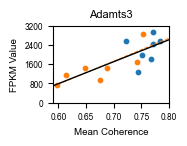


Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.47119318654988435 -0.7080378134897743 -0.7971449300581164
P [Young, MA, Aged, All]: 
0.2858370824862966 0.07502910637629706 0.0006396510354129063


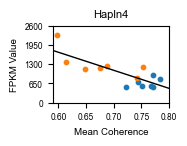

In [13]:
''' Plot Figure 7G'''

# Arrays below correspond to the following rows of Supplemental Information Table S1 rows, where each value is from a mouse:
#From C1:P1:
coherence = [0.771507,0.743562,0.751875,0.722717,0.76769,0.783099,0.771744,0.598272,0.647575,0.688719,0.614267,0.674573,0.752533,0.741628]

#From C264:P264:
adamts3 = [2434.00769,1278.451717,1996.709615,2555.452779,1832.066644,2567.381172,2951.50437,745.0741398,1460.752713,1463.475755,1138.184964,957.0021128,2874.030388,1701.103465]

#From C166:P166:
hapln4 = [535.8996691, 708.0133348, 562.140088, 541.6174085, 579.4763986, 813.0257486, 945.0704155, 2274.470467, 1131.280868, 1239.024935, 1374.522669, 1179.153181, 1204.534184, 846.2194377]

#Assess Adamts3 expression correlation with coherence
nymice = 7 # with RF sequencing data
res = stats.linregress(coherence[:nymice],adamts3[:nymice])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(coherence[nymice:],adamts3[nymice:])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(coherence,adamts3)
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, ap1, allp1)

#Plot Figure 7Gtop
fig, ax = plt.subplots(figsize = (1.5,1))
ax.set_title('Adamts3', fontsize = 8)
ax.scatter(coherence[:nymice],adamts3[:nymice], color = 'C0', label = 'Young', s = 10)
ax.scatter(coherence[nymice:],adamts3[nymice:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Mean Coherence', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([0.59,0.8])
ax.set_ylim([0,3200])
ax.set_yticks([0,800,1600,2400,3200])
ax.set_xticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '7Gtop.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '7Gtop.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Assess Hapln4 expression correlation with coherence
res = stats.linregress(coherence[:7],hapln4[:7])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(coherence[7:],hapln4[7:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(coherence,hapln4)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7Gtop
fig, ax = plt.subplots(figsize = (1.5,1))
ax.set_title('Hapln4', fontsize = 8)
ax.scatter(coherence[:nymice],hapln4[:nymice], color = 'C0', label = 'Young', s = 10)
ax.scatter(coherence[nymice:],hapln4[nymice:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Mean Coherence', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([0.59,0.8])
ax.set_ylim([0,2600])
ax.set_yticks([0,650,1300,1950,2600])
ax.set_xticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '7Gbottom.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '7Gbottom.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


# Figure 8B-D Visualizations of PNN Density & Correlative Relationships

Figure 8A is an immunohistochemical representative image. Pre-processed images and image analysis data will be made available to the public upon manuscript publication in the Dryad repository.

One mouse (Y11) in the RF sequencing dataset did not have IHC images. As such, n = 6 young, n = 7 aged mice below.

In [14]:
'''Gather Figure 8B-D Data from Spreadsheet'''
figure8bcd = pd.read_csv('C:/Users/Python/Desktop/Dryad/8BCD.csv') # adjust path name
print(figure8bcd.head())

youngPV = np.array(figure8bcd.loc[(figure8bcd.Group == 'Y'),'PVDensity'])
agedPV = np.array(figure8bcd.loc[(figure8bcd.Group == 'A'),'PVDensity'])

youngPNN = np.array(figure8bcd.loc[(figure8bcd.Group == 'Y'),'PNNDensity'])
agedPNN = np.array(figure8bcd.loc[(figure8bcd.Group == 'A'),'PNNDensity'])

youngPVPNN = np.array(figure8bcd.loc[(figure8bcd.Group == 'Y'),'PV+PNNDensity'])
agedPVPNN = np.array(figure8bcd.loc[(figure8bcd.Group == 'A'),'PV+PNNDensity'])

youngEXPNN = np.array(figure8bcd.loc[(figure8bcd.Group == 'Y'),'PV-PNNDensity'])
agedEXPNN = np.array(figure8bcd.loc[(figure8bcd.Group == 'A'),'PV-PNNDensity'])

# Arrays below correspond to the following rows of Supplemental Information Table S1 rows, where each value is from a mouse:
#From C1:D1,F1:P1:
coherence = [0.771507,0.743562,0.722717,0.76769,0.783099,0.771744,0.598272,0.647575,0.688719,0.614267,0.674573,0.752533,0.741628]

#From C166:D166,F166:P166:
hapln4 = [535.8996691, 708.0133348, 541.6174085, 579.4763986, 813.0257486, 945.0704155, 2274.470467, 1131.280868, 1239.024935, 1374.522669, 1179.153181, 1204.534184, 846.2194377]

  Mouse Group  PVDensity  PNNDensity  PV+PNNDensity  PV-PNNDensity
0    Y2     Y   0.000141    0.000030   2.193231e-05       0.000008
1    Y3     Y   0.000112    0.000022   1.741520e-05       0.000004
2   Y16     Y   0.000106    0.000004   0.000000e+00       0.000004
3   Y17     Y   0.000102    0.000023   1.964536e-05       0.000003
4   Y18     Y   0.000129    0.000003   3.908223e-07       0.000002


Young Density Mean ± SEM; Aged Density Mean ± SEM: 
0.00011749 ± 5.98e-06; 0.00013567 ± 1.022e-05

Young vs. Aged WRS Test: F, p 
-1.4285714285714286 , 0.1531274510196695


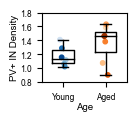


Young Density Mean ± SEM; Aged Density Mean ± SEM: 
2.275e-05 ± 7.9e-06; 4.052e-05 ± 3.97e-06

Young vs. Aged WRS Test: F, p 
-2.0 , 0.04550026389635839


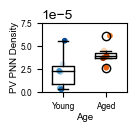

In [15]:
'Plot Figure 8B & Compare the Density of PV INs & PNNs in Young vs. Aged Mice'

# Check in PV IN Density is Altered
print('Young Density Mean ± SEM; Aged Density Mean ± SEM: ')
print(str(np.round(np.mean(youngPV),8)) + ' ± ' + str(np.round(stats.sem(youngPV),8)) + '; ' + str(np.round(np.mean(agedPV),8)) + ' ± ' + str(np.round(stats.sem(agedPV),8)))

print('\nYoung vs. Aged WRS Test: F, p ')
F, p = stats.ranksums(youngPV, agedPV)
print(str(F) + ' , ' + str(p))

#Plot Figure 8B Top
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngPV,agedPV]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV+ IN Density', fontsize=7, labelpad=1)
ax.set_ylim([0.8e-4,1.8e-4])
ax.set_yticks([0.8e-4,1.0e-4,1.2e-4,1.4e-4,1.6e-4,1.8e-4])
ax.set_yticklabels([0.8,1.0,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Btop.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Btop.svg', dpi=400, bbox_inches='tight')
plt.show()

# Check in PNN Density is Altered
print('\nYoung Density Mean ± SEM; Aged Density Mean ± SEM: ')
print(str(np.round(np.mean(youngPNN),8)) + ' ± ' + str(np.round(stats.sem(youngPNN),8)) + '; ' + str(np.round(np.mean(agedPNN),8)) + ' ± ' + str(np.round(stats.sem(agedPNN),8)))

print('\nYoung vs. Aged WRS Test: F, p ')
F, p = stats.ranksums(youngPNN, agedPNN)
print(str(F) + ' , ' + str(p))

#Plot Figure 8B Bottom
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngPNN,agedPNN]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV PNN Density', fontsize=7, labelpad=1)
ax.set_ylim([0,7.5e-5])
ax.set_yticks([0,2.5e-5,5e-5,7.5e-5])

ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Bbottom.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Bbottom.svg', dpi=400, bbox_inches='tight')
plt.show()


Young Density Mean ± SEM; Aged Density Mean ± SEM: 
1.577e-05 ± 5.53e-06; 2.551e-05 ± 2.35e-06

Young vs. Aged WRS Test: F, p 
-1.2857142857142858 , 0.19854279368666194


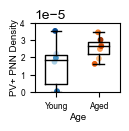


Young Density Mean ± SEM; Aged Density Mean ± SEM: 
6.99e-06 ± 2.77e-06; 1.501e-05 ± 2.49e-06

Young vs. Aged WRS Test: F, p 
-2.0 , 0.04550026389635839


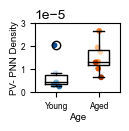

In [16]:
'Plot Figure 8C & Compare the Density of PV+ & PV- PNNs in Young vs. Aged Mice'

# Check in PV+ PNN Density is Altered
print('\nYoung Density Mean ± SEM; Aged Density Mean ± SEM: ')
print(str(np.round(np.mean(youngPVPNN),8)) + ' ± ' + str(np.round(stats.sem(youngPVPNN),8)) + '; ' + str(np.round(np.mean(agedPVPNN),8)) + ' ± ' + str(np.round(stats.sem(agedPVPNN),8)))

print('\nYoung vs. Aged WRS Test: F, p ')
F, p = stats.ranksums(youngPVPNN, agedPVPNN)
print(str(F) + ' , ' + str(p))

#Plot Figure 8C Top
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngPVPNN,agedPVPNN]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV+ PNN Density', fontsize=7, labelpad=1)
ax.set_ylim([0,4e-5])
ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Ctop.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Ctop.svg', dpi=400, bbox_inches='tight')
plt.show()

# Check in PV- PNN Density is Altered
print('\nYoung Density Mean ± SEM; Aged Density Mean ± SEM: ')
print(str(np.round(np.mean(youngEXPNN),8)) + ' ± ' + str(np.round(stats.sem(youngEXPNN),8)) + '; ' + str(np.round(np.mean(agedEXPNN),8)) + ' ± ' + str(np.round(stats.sem(agedEXPNN),8)))

print('\nYoung vs. Aged WRS Test: F, p ')
F, p = stats.ranksums(youngEXPNN, agedEXPNN)
print(str(F) + ' , ' + str(p))

#Plot Figure 8C Bottom
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngEXPNN,agedEXPNN]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV- PNN Density', fontsize=7, labelpad=1)
ax.set_ylim([0,3e-5])
ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Cbottom.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Cbottom.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, Aged, & All Decoder Score vs. hapln4:
R [Young, Aged, All]: 
0.6101261383055151 0.4038991467743186 0.6288532439762436
P [Young, MA, Aged, All]: 
0.19837171119640187 0.3688520609681763 0.021314658383825593


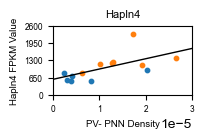


Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.24954817430850634 -0.7503261022427545 -0.6596114576999756
P [Young, MA, Aged, All]: 
0.6334479563874644 0.05202133212768575 0.014171880333135932


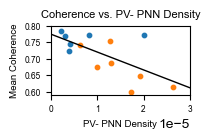

In [17]:
'''Plot Figure 8D'''

nymice = 6

#Hapln4 vs. EXPNN
res = stats.linregress(youngEXPNN,hapln4[:nymice])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(agedEXPNN,hapln4[nymice:])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(np.concatenate((youngEXPNN, agedEXPNN)),hapln4)
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. hapln4:')
print('R [Young, Aged, All]: ')
print(yr1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, ap1, allp1)

#Plot Figure 7Rtop
fig, ax = plt.subplots(figsize = (1.8,0.9))
ax.set_title('Hapln4', fontsize = 8)
ax.scatter(youngEXPNN, hapln4[:nymice], color = 'C0', label = 'Young', s = 10)
ax.scatter(agedEXPNN, hapln4[nymice:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Hapln4 FPKM Value', fontsize = 7)
ax.set_xlabel('PV- PNN Density', fontsize = 7)
ax.set_ylim([0,2600])
ax.set_yticks([0,650,1300,1950,2600])
ax.set_xlim([0,3e-5])
ax.set_xticks([0,1e-5,2e-5,3e-5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope1*X_plot + yint1, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '8Dtop.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '8Dtop.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Coherence vs EXPNN
res = stats.linregress(youngEXPNN,coherence[:nymice],)
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(agedEXPNN,coherence[nymice:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(np.concatenate((youngEXPNN, agedEXPNN)),coherence)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7:bottom
fig, ax = plt.subplots(figsize = (1.8,0.9))
ax.set_title('Coherence vs. PV- PNN Density', fontsize = 8)
ax.scatter(youngEXPNN, coherence[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter( agedEXPNN,coherence[6:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Mean Coherence', fontsize = 7)
ax.set_xlabel('PV- PNN Density', fontsize = 7)
ax.set_ylim([0.59,0.8])
ax.set_xlim([0,3e-5])
ax.set_xticks([0,1e-5,2e-5,3e-5])
ax.set_yticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '8Dbottom.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '8Dbottom.svg', dpi = 400, bbox_inches = 'tight')
plt.show()



Association btwn Young, Aged, & All Young PVPNN vs. Hapln4:
R [Young, Aged, All]: 
0.35977402982458057 0.16050834048161913 0.42976010402978265
P [Young, MA, Aged, All]: 
0.4836230542290193 0.7310090087717408 0.14274113824851173


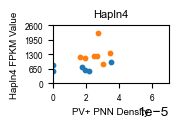


Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.35115473700801436 -0.06917837213079693 -0.28009563002260235
P [Young, MA, Aged, All]: 
0.4949182782272921 0.8828399613498289 0.35398595674689826


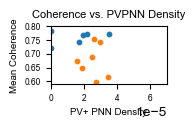

In [18]:
'''Plot 8D with PV+ PVPNNs'''

#Hapln4 PVPNN
res = stats.linregress(youngPVPNN,hapln4[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(agedPVPNN,hapln4[nymice:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(np.concatenate((youngPVPNN, agedPVPNN)),hapln4)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Young PVPNN vs. Hapln4:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7Ptop
fig, ax = plt.subplots(figsize = (1.5,0.75))
ax.set_title('Hapln4', fontsize = 8)
ax.scatter(youngPVPNN, hapln4[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(agedPVPNN, hapln4[6:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Hapln4 FPKM Value', fontsize = 7)
ax.set_xlabel('PV+ PNN Density', fontsize = 7)
ax.set_ylim([0,2600])
ax.set_yticks([0,650,1300,1950,2600])
ax.set_xlim([0,7e-5])
ax.set_xticks([0,2e-5,4e-5,6e-5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.show()

#Coherence vs PVPNN
res = stats.linregress(youngPVPNN,coherence[:nymice],)
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(agedPVPNN,coherence[nymice:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(np.concatenate((youngPVPNN, agedPVPNN)),coherence)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7:bottom
fig, ax = plt.subplots(figsize = (1.5,0.75))
ax.set_title('Coherence vs. PVPNN Density', fontsize = 8)
ax.scatter(youngPVPNN, coherence[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter( agedPVPNN,coherence[6:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Mean Coherence', fontsize = 7)
ax.set_xlabel('PV+ PNN Density', fontsize = 7)
ax.set_ylim([0.59,0.8])
ax.set_xlim([0,7e-5])
ax.set_xticks([0,2e-5,4e-5,6e-5])
ax.set_yticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.show()


# Extended Data Fig. 8B-C, Q Visualizations of SM Transcriptomic Data Correlates of Spatial Coding and Memory


            Gene         r         T         p  sig  sigFDR
0  RP24-359F24.1 -0.750228  4.538722  0.000336    1       0
1           Mpnd  0.735185  4.338234  0.000509    1       0
2            Dxo  0.726502  4.228984  0.000639    1       0
3       Tmem106a -0.713216  4.070028  0.000891    1       0
4           Mtpn -0.706642  3.994748  0.001043    1       0

n FDR-corrected sig negative vs. positive coherence correlates: 
301 vs. 219


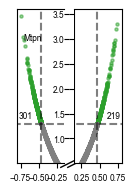

In [19]:
''' Plot Extended Data Fig. 8B Left

In Illustrator, the y-axis line was moved to be centered between these panels at the axis break, and y-axis tick labels were 
move to the right side of the axis for improved visibility.

'''
#Gather Data
s8cbehavior = pd.read_csv('C:/Users/Python/Desktop/Dryad/S8C_Left.csv') # adjust path name
print(s8cbehavior.head())

sigcorrR = np.array(s8cbehavior.loc[(s8cbehavior.sig == 1),'r'])
nscorrR = np.array(s8cbehavior.loc[(s8cbehavior.sig == 0),'r'])

sigcorrp = np.array(s8cbehavior.loc[(s8cbehavior.sig == 1),'p'])
nscorrp = np.array(s8cbehavior.loc[(s8cbehavior.sig == 0),'p'])

mtpnp = np.array(s8cbehavior.loc[(s8cbehavior.Gene == 'Mtpn'),'p'])
mtpnr = np.array(s8cbehavior.loc[(s8cbehavior.Gene == 'Mtpn'),'r'])

print('\nn FDR-corrected sig negative vs. positive coherence correlates: ')
print(str(len(np.array(s8cbehavior.loc[(s8cbehavior.sig == 1) & (s8cbehavior.r < 0),'Gene']))) + ' vs. ' + str(len(np.array(s8cbehavior.loc[(s8cbehavior.sig == 1) & (s8cbehavior.r > 0),'Gene']))))

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

#Plot data
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (1.35,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)

ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax1.set_xlim([-0.8,-0.15])
ax1.set_xticks([-0.75,-0.5,-0.25])
ax1.yaxis.tick_right()
ax1.tick_params(labelsize = 6)
ax1.spines.right.set_visible(False)

ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax2.set_xlim([0.15,0.8])
ax2.set_xticks([0.25,0.5,0.75])
ax2.set_ylim([0.5,3.6])
ax2.set_yticks([0.5,1,1.5,2,2.5,3,3.5])
ax2.spines.left.set_visible(False)
ax2.tick_params(labelleft = True, labelsize = 6)
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_yticks([1.0,1.5,2.0,2.5,3.0,3.5])
ax2.set_yticklabels([1.0,1.5,2.0,2.5,3.0,3.5])

#add vertical / horizontal lines at p < 0.05 threshold 
ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.5,3.6,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.5,3.6,'k','--',alpha = 0.5)
ax2.vlines(0.15,0.5,3.6,'k','-',alpha = 1.0)

#annotate with gene plotted in S8C
ax1.annotate('Mtpn',(mtpnr,-1*np.log10(mtpnp)),fontsize = 6)

#annotate with correlate nummbers
ax1.annotate(str(len(np.array(s8cbehavior.loc[(s8cbehavior.sig == 1) & (s8cbehavior.r < 0),'Gene']))), (-0.78, 1.4), fontsize = 6)
ax2.annotate(str(len(np.array(s8cbehavior.loc[(s8cbehavior.sig == 1) & (s8cbehavior.r > 0),'Gene']))), (0.6, 1.4), fontsize = 6)

#add slanted line break
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)
#ax2.plot([0,1],[1,1], transform=ax2.transAxes,**kwargs)

plt.savefig(save_folder + 'S8Bleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Bleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


            Gene         r         T         p  sig  sigFDR
0       Mettl21b -0.791457  5.179475  0.000091    1       0
1           Mtpn -0.785361  5.074717  0.000113    1       0
2       Tmem106a -0.748651  4.516986  0.000351    1       0
3  RP24-359F24.1 -0.747417  4.500109  0.000363    1       0
4            Gss  0.728026  4.247834  0.000614    1       0

n FDR-corrected sig negative vs. positive coherence correlates: 
379 vs. 247


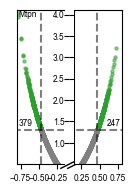

In [20]:
''' Plot Extended Data Fig. 8B Middle

In Illustrator, the y-axis line was moved to be centered between these panels at the axis break, and y-axis tick labels were 
move to the right side of the axis for improved visibility.

'''
#Gather Data
s8cfracaligned = pd.read_csv('C:/Users/Python/Desktop/Dryad/S8C_Middle.csv') # adjust path name
print(s8cfracaligned.head())

sigcorrR = np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 1),'r'])
nscorrR = np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 0),'r'])

sigcorrp = np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 1),'p'])
nscorrp = np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 0),'p'])

mtpnp = np.array(s8cfracaligned.loc[(s8cfracaligned.Gene == 'Mtpn'),'p'])
mtpnr = np.array(s8cfracaligned.loc[(s8cfracaligned.Gene == 'Mtpn'),'r'])

print('\nn FDR-corrected sig negative vs. positive coherence correlates: ')
print(str(len(np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 1) & (s8cfracaligned.r < 0),'Gene']))) + ' vs. ' + str(len(np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 1) & (s8cfracaligned.r > 0),'Gene']))))

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

#Plot data
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (1.35,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)

ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax1.set_xlim([-0.8,-0.15])
ax1.set_xticks([-0.75,-0.5,-0.25])
ax1.yaxis.tick_right()
ax1.tick_params(labelsize = 6)
ax1.spines.right.set_visible(False)

ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax2.set_xlim([0.15,0.8])
ax2.set_xticks([0.25,0.5,0.75])
ax2.set_ylim([0.5,4.1])
ax2.set_yticks([0.5,1,1.5,2,2.5,3,3.5,4])
ax2.spines.left.set_visible(False)
ax2.tick_params(labelleft = True, labelsize = 6)
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_yticks([1.0,1.5,2.0,2.5,3.0,3.5,4])
ax2.set_yticklabels([1.0,1.5,2.0,2.5,3.0,3.5,4.0])

#add vertical / horizontal lines at p < 0.05 threshold 
ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.5,4.1,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.5,4.1,'k','--',alpha = 0.5)
ax2.vlines(0.15,0.5,4.1,'k','-',alpha = 1.0)

#annotate with gene plotted in S8C
ax1.annotate('Mtpn',(mtpnr,-1*np.log10(mtpnp)),fontsize = 6)

#annotate with correlate nummbers
ax1.annotate(str(len(np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 1) & (s8cfracaligned.r < 0),'Gene']))), (-0.78, 1.4), fontsize = 6)
ax2.annotate(str(len(np.array(s8cfracaligned.loc[(s8cfracaligned.sig == 1) & (s8cfracaligned.r > 0),'Gene']))), (0.6, 1.4), fontsize = 6)

#add slanted line break
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)
#ax2.plot([0,1],[1,1], transform=ax2.transAxes,**kwargs)

plt.savefig(save_folder + 'S8Bmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Bmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


      Gene         r         T         p  sig  sigFDR
0    Ssbp4 -0.869941  7.056121  0.000003    1       1
1   Gabra2 -0.869417  7.038677  0.000003    1       1
2  Dynlt1b -0.865978  6.926675  0.000003    1       1
3  Gm15446  0.853121  6.540908  0.000007    1       1
4    Pcid2 -0.817698  5.681932  0.000034    1       0

n FDR-corrected sig negative vs. positive coherence correlates: 
616 vs. 422


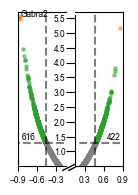

In [21]:
''' Plot Extended Data Fig. 8B Right

In Illustrator, the y-axis line was moved to be centered between these panels at the axis break, and y-axis tick labels were 
move to the right side of the axis for improved visibility.

'''
#Gather Data
s8cremap = pd.read_csv('C:/Users/Python/Desktop/Dryad/S8C_Right.csv') # adjust path name
print(s8cremap.head())

sigFDRcorrR = np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.sigFDR == 1),'r'])
sigcorrR = np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.sigFDR == 0),'r'])
nscorrR = np.array(s8cremap.loc[(s8cremap.sig == 0),'r'])

sigFDRcorrp = np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.sigFDR == 1),'p'])
sigcorrp = np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.sigFDR == 0),'p'])
nscorrp = np.array(s8cremap.loc[(s8cremap.sig == 0),'p'])

gabra2p = np.array(s8cremap.loc[(s8cremap.Gene == 'Gabra2'),'p'])
gabra2r = np.array(s8cremap.loc[(s8cremap.Gene == 'Gabra2'),'r'])

print('\nn FDR-corrected sig negative vs. positive coherence correlates: ')
print(str(len(np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.r < 0),'Gene']))) + ' vs. ' + str(len(np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.r > 0),'Gene']))))

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

#Plot data
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (1.35,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)
ax1.scatter(sigFDRcorrR,-1*np.log10(sigFDRcorrp), color = 'C1', alpha = 0.5, s = 5)
ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax1.set_xlim([-0.9,-0.15])
ax1.set_xticks([-0.9,-0.6,-0.3])
ax1.yaxis.tick_right()
ax1.tick_params(labelsize = 6)
ax1.spines.right.set_visible(False)

ax2.scatter(sigFDRcorrR,-1*np.log10(sigFDRcorrp), color = 'C1', alpha = 0.5, s = 5)
ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax2.set_xlim([0.15,0.9])
ax2.set_xticks([0.3,0.6,0.9])
ax2.set_ylim([0.5,5.7])
ax2.set_yticks([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])
ax2.spines.left.set_visible(False)
ax2.tick_params(labelleft = True, labelsize = 6)
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_yticks([1.0,1.5,2.0,2.5,3.0,3.5,4,4.5,5,5.5])
ax2.set_yticklabels([1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5])

#add vertical / horizontal lines at p < 0.05 threshold 
ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.5,5.7,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.5,5.7,'k','--',alpha = 0.5)
ax2.vlines(0.15,0.5,5.6,'k','-',alpha = 1.0)

#annotate with gene plotted in S8C
ax1.annotate('Gabra2',(gabra2r,-1*np.log10(gabra2p)),fontsize = 6)

#annotate with correlate nummbers
ax1.annotate(str(len(np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.r < 0),'Gene']))), (-0.85, 1.4), fontsize = 6)
ax2.annotate(str(len(np.array(s8cremap.loc[(s8cremap.sig == 1) & (s8cremap.r > 0),'Gene']))), (0.65, 1.4), fontsize = 6)

#add slanted line break
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)
#ax2.plot([0,1],[1,1], transform=ax2.transAxes,**kwargs)

plt.savefig(save_folder + 'S8Bright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Bright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()



Association btwn Young, MA, Aged, & All Mtpn vs. Change in Alt Frac. Req
R [Young, Aged, All]: 
-0.6073658832297203 0.2269916366302728 0.6881929495886212 -0.7066421464280799
P [Young, MA, Aged, All]: 
0.20097778253419524 0.6653604401442892 0.13067794733666344 0.0010434830929581397


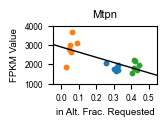


Association btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:
R [Young, Aged, All]: 
-0.854772189082721 -0.230145408595067 0.2840847557220249 -0.785360883938715
P [Young, MA, Aged, All]: 
0.030105167215247728 0.6608769325755178 0.5853362755637253 0.00011259646759687579


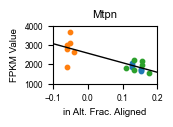


Association btwn Young, MA, Aged, & All Alt. Remapping Freq:
R [Young, Aged, All]: 
-0.028544379590161168 0.1999932886870057 -0.3883781874264254 -0.8694166848386659
P [Young, MA, Aged, All]: 
0.9571950593324833 0.7040096643042242 0.4467237389002676 2.799733649282276e-06


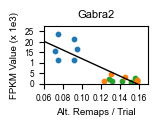

In [11]:
''' Plot Extended Data Fig. 8C '''
nymice = 6
nmamice = 6

# Arrays below correspond to the following rows of Supplemental Information Table S2 rows, where each value is from a mouse:
## SEE TAB 2
#From C1:T1:
behavior = [0.257799,0.311668,0.321791,0.319969,0.303089,0.322289,0.421861,0.41576,0.445066,0.403321,0.415839,0.432759,0.060951,0.055986,0.087271,0.025026,0.04029,0.050669]
#From C2:T2:
fracaligned = [0.126553,0.151863,0.151863,0.126553,0.151863,0.126552,0.154545,0.110389,0.154545,0.176623,0.132467,0.132467,-0.049954,-0.039964,-0.049955,-0.059946,-0.059946,-0.059946]
#From C3:T3:
remapfreq = [0.071971,0.0754,0.0754,0.091645,0.095074,0.091645,0.15783,0.128946,0.132446,0.142946,0.15223,0.15643,0.131168,0.123771,0.145961,0.158238,0.158238,0.158238]
#From C9:T9:
mtpn = [2077.613307,1680.409735,1713.971316,1844.118878,1780.820656,1984.860489,2156.837812,1836.161707,1989.678908,1551.350236,2253.11969,1692.371425,3704.186916,2657.341693,3136.999221,1854.415688,2804.86934,3012.776551]
#From C8341:T8341:
gabra2 = [15759.13646,11235.44523,23606.63313,11091.98657,16717.31204,21455.4798,1805.136953,2082.048142,1039.74403,1169.752883,936.5640468,2444.497356,4344.601994,1139.070836,2915.195789,1792.112699,886.1942631,1413.803835]
#From C9011:T9011:
egr1 = [1046.813834,1910.143313,1768.46177,3563.943914,1109.375195,2482.352907,3174.649182,1696.101779,1399.826301,1650.854012,2792.348611,2125.798969,3330.430531,3189.258313,4443.43422,1391.719477,1725.042651,1479.942271]
#From C6839:T6839:
arc = [2596.988733,3534.566302,4750.366731,4492.280658,2835.214967,3518.543982,4309.795667,4478.890383,1159.850154,3494.217766,4256.690128,704.435914,6758.533199,6395.058947,5332.508232,2742.934978,1934.945579,2245.915838]

## Assess correlation of behavior vs. expression
res = stats.linregress(behavior[:nymice],mtpn[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(behavior[nymice:(nymice + nmamice)],mtpn[nymice:(nymice + nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(behavior[(nymice + nmamice):],mtpn[(nymice + nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(behavior,mtpn)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Mtpn vs. Change in Alt Frac. Req')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Extended Data Fig. 8Cleft
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Mtpn', fontsize = 8)
ax.scatter(behavior[:nymice],mtpn[:nymice], color = 'C0', label = 'Young', s = 10)
ax.scatter(behavior[nymice:(nymice+nmamice)],mtpn[nymice:(nymice+nmamice)], color = 'C2', label = 'MA', s = 10)
ax.scatter(behavior[(nymice+nmamice):],mtpn[(nymice+nmamice):], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('in Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.05,0.55])
ax.set_ylim([1000,4000])
ax.set_yticks([1000,2000,3000,4000])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Cleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Cleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

## Assess correlation of fracaligned vs. expression
res = stats.linregress(fracaligned[:nymice],mtpn[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(fracaligned[nymice:(nymice+nmamice)],mtpn[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(fracaligned[(nymice+nmamice):],mtpn[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(fracaligned, mtpn)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Extended Data Fig. 8Cmiddle
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Mtpn', fontsize = 8)
ax.scatter(fracaligned[:nymice],mtpn[:nymice], color = 'C0', label = 'Young', s = 10)
ax.scatter(fracaligned[nymice:(nymice+nmamice)],mtpn[nymice:(nymice+nmamice)], color = 'C2', label = 'MA', s = 10)
ax.scatter(fracaligned[(nymice+nmamice):],mtpn[(nymice+nmamice):], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('in Alt. Frac. Aligned', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.1,0.2])
ax.set_ylim([1000,4000])
ax.set_yticks([1000,2000,3000,4000])
ax.set_xticks([-0.1,0,0.1,0.2])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Cmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Cmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

## Assess correlation of remapping frequency vs. expression
res = stats.linregress(remapfreq[:nymice],gabra2[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(remapfreq[nymice:(nymice+nmamice)],gabra2[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(remapfreq[(nymice+nmamice):],gabra2[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(remapfreq, gabra2)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Alt. Remapping Freq:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Extended Data Fig. 8Cright
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Gabra2', fontsize = 8)
ax.scatter(remapfreq[:nymice],gabra2[:nymice], color = 'C0', label = 'Young', s = 10)
ax.scatter(remapfreq[nymice:(nymice+nmamice)],gabra2[nymice:(nymice+nmamice)], color = 'C2', label = 'MA', s = 10)
ax.scatter(remapfreq[(nymice+nmamice):],gabra2[(nymice+nmamice):], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Alt. Remaps / Trial', fontsize = 7)
ax.set_ylabel('FPKM Value (x 1e3)', fontsize = 7)
ax.set_xlim([0.06,0.17])
ax.set_ylim([-100,27500])
ax.set_yticks([0,5000,10000,15000,20000,25000])
ax.set_yticklabels([0,5,1,15,20,25])
ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Cright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Cright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All egr1 vs. Change in Alt Frac. Req
R [Young, Aged, All]: 
0.634216460836225 -0.1838348522120269 0.9063587652800464 -0.1617133002889403
P [Young, MA, Aged, All]: 
0.17622591690794626 0.7273540943420097 0.012742466209460493 0.5214723933964371


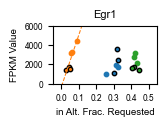


Association btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:
R [Young, Aged, All]: 
0.10846462738339158 -0.13761243555985495 0.8932595652075174 -0.24021296664450412
P [Young, MA, Aged, All]: 
0.8379410790680981 0.7948843425579956 0.016482205967825073 0.33698917949422813


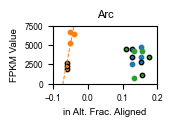


Association btwn Young, MA, Aged, & All Alt. Remapping Freq:
R [Young, Aged, All]: 
0.01182672751840573 -0.019627727796524202 -0.9406816391729679 -0.16309873059545577
P [Young, MA, Aged, All]: 
0.9822607358333546 0.9705621890736935 0.005173641089822076 0.5178620980254787


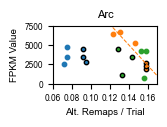

In [12]:
''' Plot Extended Data Fig. 8Q ''' 
MAfemale = [6, 10, 11]
MAmale = [7, 8, 9]

## Assess correlation of behavior vs. expression
res = stats.linregress(behavior[:nymice],egr1[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(behavior[nymice:(nymice+nmamice)],egr1[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(behavior[(nymice+nmamice):],egr1[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(behavior,egr1)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All egr1 vs. Change in Alt Frac. Req')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Extended Data Fig. 8Qleft
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Egr1', fontsize = 8)
ax.scatter(behavior[:3],egr1[:3], color = 'C0', label = 'Young Female', s = 10)
ax.scatter(behavior[3:6],egr1[3:6], color = 'C0', edgecolor = 'k',label = 'Young Male', s = 10)
ax.scatter([behavior[x] for x in MAfemale],[egr1[x] for x in MAfemale], color = 'C2', label = 'MA Female', s = 10)
ax.scatter([behavior[x] for x in MAmale],[egr1[x] for x in MAmale], color = 'C2', edgecolor = 'k', label = 'MA Male', s = 10)
ax.scatter(behavior[12:15],egr1[12:15], color = 'C1', label = 'Aged Female', s = 10)
ax.scatter(behavior[15:],egr1[15:], color = 'C1', edgecolor='k', label = 'Aged Male', s = 10)
ax.set_xlabel('in Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.05,0.55])
ax.set_ylim([0,6000])
ax.set_yticks([0,2000,4000,6000])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
#ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Qleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Qleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

## Assess correlation of frac aligned vs. expression
res = stats.linregress(fracaligned[:nymice],arc[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(fracaligned[nymice:(nymice+nmamice)],arc[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(fracaligned[(nymice+nmamice):],arc[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(fracaligned, arc)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Extended Data Fig. 8Qmiddle
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Arc', fontsize = 8)
ax.scatter(fracaligned[:3],arc[:3], color = 'C0', label = 'Young Female', s = 10)
ax.scatter(fracaligned[3:6],arc[3:6], color = 'C0', edgecolor = 'k',label = 'Young Male', s = 10)
ax.scatter([fracaligned[x] for x in MAfemale],[arc[x] for x in MAfemale], color = 'C2', label = 'MA Female', s = 10)
ax.scatter([fracaligned[x] for x in MAmale],[arc[x] for x in MAmale], color = 'C2', edgecolor = 'k', label = 'MA Male', s = 10)
ax.scatter(fracaligned[12:15],arc[12:15], color = 'C1', label = 'Aged Female', s = 10)
ax.scatter(fracaligned[15:],arc[15:], color = 'C1', edgecolor='k', label = 'Aged Male', s = 10)
ax.set_xlabel('in Alt. Frac. Aligned', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.1,0.2])
ax.set_ylim([0,7500])
ax.set_yticks([0,2500,5000,7500])
ax.set_xticks([-0.1,0,0.1,0.2])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
#ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Qmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Qmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

## Assess correlation of remapping freq vs. expression
res = stats.linregress(remapfreq[:nymice],arc[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(remapfreq[nymice:(nymice+nmamice)],arc[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(remapfreq[(nymice+nmamice):],arc[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(remapfreq, arc)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Alt. Remapping Freq:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Extended Data Fig. 8Qright
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Arc', fontsize = 8)
ax.scatter(remapfreq[:3],arc[:3], color = 'C0', label = 'Young Female', s = 10)
ax.scatter(remapfreq[3:6],arc[3:6], color = 'C0', edgecolor = 'k',label = 'Young Male', s = 10)
ax.scatter([remapfreq[x] for x in MAfemale],[arc[x] for x in MAfemale], color = 'C2', label = 'MA Female', s = 10)
ax.scatter([remapfreq[x] for x in MAmale],[arc[x] for x in MAmale], color = 'C2', edgecolor = 'k', label = 'MA Male', s = 10)
ax.scatter(remapfreq[12:15],arc[12:15], color = 'C1', label = 'Aged Female', s = 10)
ax.scatter(remapfreq[15:],arc[15:], color = 'C1', edgecolor='k', label = 'Aged Male', s = 10)
ax.set_xlabel('Alt. Remaps / Trial', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([0.06,0.17])
ax.set_ylim([0,7500])
ax.set_yticks([0,2500,5000,7500])
ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
#ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Qright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Qright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All Alt. Performance:
R [Young, Aged, All]: 
-0.5453447553960097 0.4395551274540668 -0.6921829750468677 -0.5467928308765162
P [Young, MA, Aged, All]: 
0.26307587804873467 0.38313024840918236 0.12754394642912903 0.01886443230900337


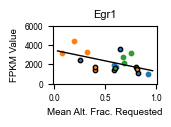


Association btwn Young, MA, Aged, & All Alt. Perforance:
R [Young, Aged, All]: 
-0.4186698284831865 0.5422956939240451 -0.7045217604794975 -0.45942869916573975
P [Young, MA, Aged, All]: 
0.4086884074095442 0.2662968705562852 0.1180623680935859 0.055100594015333626


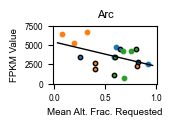

In [27]:
'''Examine relationship between mean performance across sessions and Arc/Egr1 '''
mreqalt_rates = np.array([0.92484342, 0.58628842, 0.60842105, 0.64791667, 0.82083333, 0.25208333,
                          0.75833333,  0.80625, 0.58333333, 0.59583333, 0.67708333, 0.6875,
                          0.32489451, 0.07575758, 0.19578947,0.40208333,0.39808153,0.81666667])

## Assess correlation of alt performance vs. egr1
res = stats.linregress(mreqalt_rates[:nymice],egr1[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(mreqalt_rates[nymice:(nymice+nmamice)],egr1[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(mreqalt_rates[(nymice+nmamice):],egr1[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(mreqalt_rates, egr1)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Alt. Performance:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Egr1', fontsize = 8)
ax.scatter(mreqalt_rates[:3],egr1[:3], color = 'C0', label = 'Young Female', s = 10)
ax.scatter(mreqalt_rates[3:6],egr1[3:6], color = 'C0', edgecolor = 'k',label = 'Young Male', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAfemale],[egr1[x] for x in MAfemale], color = 'C2', label = 'MA Female', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAmale],[egr1[x] for x in MAmale], color = 'C2', edgecolor = 'k', label = 'MA Male', s = 10)
ax.scatter(mreqalt_rates[12:15],egr1[12:15], color = 'C1', label = 'Aged Female', s = 10)
ax.scatter(mreqalt_rates[15:],egr1[15:], color = 'C1', edgecolor='k', label = 'Aged Male', s = 10)
ax.set_xlabel('Mean Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
#ax.set_xlim([0.06,0.17])
ax.set_ylim([0,6000])
ax.set_yticks([0,2000,4000,6000])
#ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'figure43dissertation_left.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'figure43dissertation_left.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

## Assess correlation of alt performance vs. arc
res = stats.linregress(mreqalt_rates[:nymice],arc[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(mreqalt_rates[nymice:(nymice+nmamice)],arc[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(mreqalt_rates[(nymice+nmamice):],arc[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(mreqalt_rates, arc)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Alt. Perforance:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Arc', fontsize = 8)
ax.scatter(mreqalt_rates[:3],arc[:3], color = 'C0', label = 'Young Female', s = 10)
ax.scatter(mreqalt_rates[3:6],arc[3:6], color = 'C0', edgecolor = 'k',label = 'Young Male', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAfemale],[arc[x] for x in MAfemale], color = 'C2', label = 'MA Female', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAmale],[arc[x] for x in MAmale], color = 'C2', edgecolor = 'k', label = 'MA Male', s = 10)
ax.scatter(mreqalt_rates[12:15],arc[12:15], color = 'C1', label = 'Aged Female', s = 10)
ax.scatter(mreqalt_rates[15:],arc[15:], color = 'C1', edgecolor='k', label = 'Aged Male', s = 10)
ax.set_xlabel('Mean Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
#ax.set_xlim([0.06,0.17])
ax.set_ylim([0,7500])
ax.set_yticks([0,2500,5000,7500])
#ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'figure43dissertation_right.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'figure43dissertation_right.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All Alt. Performance:
R [Young, Aged, All]: 
-0.23980018911439904 0.08516949412883874 -0.6369658273630708 -0.44489901714661534
P [Young, MA, Aged, All]: 
0.6471944670366774 0.8725546618646509 0.17376788727610587 0.06431100251809502


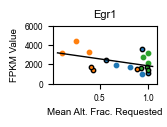


Association btwn Young, MA, Aged, & All Alt. Perforance:
R [Young, Aged, All]: 
-0.17799246830347087 -0.4021461017284128 -0.6541701643897343 -0.49183436090308263
P [Young, MA, Aged, All]: 
0.7358308156085301 0.429298680215984 0.15871708687179847 0.038157137867672754


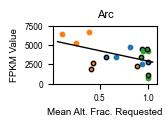

In [25]:
'''Examine relationship between Day 6 performance across sessions and Arc/Egr1 '''
mreqalt_rates = np.array([0.9367088607594937, 0.6666666666666666, 0.8076923076923077, 0.9375, 1.0, 0.5625,
                          1.0,  0.9875, 1.0, 0.925, 0.95, 1.0,
                          0.3875, 0.11392405063291139, 0.2625,0.4375,0.4117647058823529,0.8875])

## Assess correlation of alt performance vs. egr1
res = stats.linregress(mreqalt_rates[:nymice],egr1[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(mreqalt_rates[nymice:(nymice+nmamice)],egr1[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(mreqalt_rates[(nymice+nmamice):],egr1[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(mreqalt_rates, egr1)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Alt. Performance:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Egr1', fontsize = 8)
ax.scatter(mreqalt_rates[:3],egr1[:3], color = 'C0', label = 'Young Female', s = 10)
ax.scatter(mreqalt_rates[3:6],egr1[3:6], color = 'C0', edgecolor = 'k',label = 'Young Male', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAfemale],[egr1[x] for x in MAfemale], color = 'C2', label = 'MA Female', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAmale],[egr1[x] for x in MAmale], color = 'C2', edgecolor = 'k', label = 'MA Male', s = 10)
ax.scatter(mreqalt_rates[12:15],egr1[12:15], color = 'C1', label = 'Aged Female', s = 10)
ax.scatter(mreqalt_rates[15:],egr1[15:], color = 'C1', edgecolor='k', label = 'Aged Male', s = 10)
ax.set_xlabel('Mean Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
#ax.set_xlim([0.06,0.17])
ax.set_ylim([0,6000])
ax.set_yticks([0,2000,4000,6000])
#ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
#plt.savefig(save_folder + 'figure43dissertation_left.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'figure43dissertation_left.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

## Assess correlation of alt performance vs. arc
res = stats.linregress(mreqalt_rates[:nymice],arc[:nymice])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(mreqalt_rates[nymice:(nymice+nmamice)],arc[nymice:(nymice+nmamice)])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(mreqalt_rates[(nymice+nmamice):],arc[(nymice+nmamice):])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(mreqalt_rates, arc)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Alt. Perforance:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Arc', fontsize = 8)
ax.scatter(mreqalt_rates[:3],arc[:3], color = 'C0', label = 'Young Female', s = 10)
ax.scatter(mreqalt_rates[3:6],arc[3:6], color = 'C0', edgecolor = 'k',label = 'Young Male', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAfemale],[arc[x] for x in MAfemale], color = 'C2', label = 'MA Female', s = 10)
ax.scatter([mreqalt_rates[x] for x in MAmale],[arc[x] for x in MAmale], color = 'C2', edgecolor = 'k', label = 'MA Male', s = 10)
ax.scatter(mreqalt_rates[12:15],arc[12:15], color = 'C1', label = 'Aged Female', s = 10)
ax.scatter(mreqalt_rates[15:],arc[15:], color = 'C1', edgecolor='k', label = 'Aged Male', s = 10)
ax.set_xlabel('Mean Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
#ax.set_xlim([0.06,0.17])
ax.set_ylim([0,7500])
ax.set_yticks([0,2500,5000,7500])
#ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
#plt.savefig(save_folder + 'figure43dissertation_right.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'figure43dissertation_right.svg', dpi = 400, bbox_inches = 'tight')
plt.show()